In [13]:
import requests
from bs4 import BeautifulSoup
from tabulate import tabulate
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By

''' 
This program merges all of the separate programs (protagonists.ipynb and synopsis.ipynb) and adds the text search function. It will
return all of the movies that contain family keywords inside a data frame. This program runs in approximately 7-8 mins."
'''

def movie_table(url):
    webpage = url
    response = requests.get(webpage)

    page = response.text

    soup = BeautifulSoup(page, 'html.parser')
    beautiful_page = soup.get_text()

    ratings = []
    years = []
    titles = []
    movie_nums = []

    lines = beautiful_page.splitlines()

    for line in lines:
        if "(20" in line and ")" in line or '(19' in line and ')' in line:
            years.append(line)

    rep_years = []
    nrep_years = []
    year_indices = []

    for year in years:
        
        if lines.count(year) > 1:
            if year not in rep_years:
                rep_years.append(year)
        if lines.count(year) == 1:
            nrep_years.append(year)

    for i in range(len(rep_years)):
        first_instance = lines.index(rep_years[i])
        year_indices.append(first_instance)

        for j, item in enumerate(lines[first_instance+1:], start=first_instance+1):
            if item == rep_years[i]:
                year_indices.append(j)

    for year in nrep_years:
        if year in lines:
            index = lines.index(year)
            year_indices.append(index)


    for index in sorted(year_indices):
        title = lines[index-1]
        titles.append(title)

        rating = lines[index+6]
        ratings.append(rating)

        movie_num = lines[index-3]
        movie_nums.append(movie_num) 
        

    ratings = [rating.lstrip() for rating in ratings]
    for i in range(len(ratings)):
        if ratings[i] == '':
            ratings[i] = "None"


    for i in range(len(years)):
        for j in range(len(years[i])):
            if years[i][j].isnumeric():
                number_index = years[i].find(years[i][j])
                years[i] = years[i][number_index:number_index+4]
                break


    table_data = list(zip(movie_nums, titles, years, ratings))
    # headers = ["Movie Number", "Title", "Year", "Rating"]

    # print(tabulate(table_data, headers=headers))
    
    return table_data

synopsis_list = []

# Function to get the synopsis from every movie in the webpage
def synopses(link):
    webpage = link
    response = requests.get(webpage)

    page = response.text

    soup = BeautifulSoup(page, 'html.parser')

    url_list = []
    movie_url_list = []
    movie_ref_nums = []

    # Get all the hyperlinks
    for link in soup.find_all('a'):
        url_list.append(link.get('href'))

    # Filter to get movie title hyperlinks
    for url in url_list:
        if '/title/tt' in url:
            if url not in movie_url_list:
                movie_url_list.append(url) 

    # Take the reference number from the movie url
    for movie_url in movie_url_list:
        movie_ref_nums.append(movie_url[7:16])


    # Extract the synopsis from every movie then append to a list
    driver = webdriver.Chrome('/Users/nixoncarino/Desktop/chromedriver')

    for i in movie_ref_nums:
        url = "https://www.imdb.com/title/" + i + "/plotsummary/?ref_=tt_stry_pl#synopsis"
        try:
            driver.get(url)
            synopsis_element = driver.find_element(By.XPATH, '//*[@id="__next"]/main/div/section/div/section/div/div[1]/section[2]/div[2]/ul/li/div/div/div/div/div')
        except:
            synopsis_list.append("No Synopsis")
        else:
            synopsis = synopsis_element.text
            synopsis_list.append(synopsis)

# Function that find family related words on the synopsis
def text_search(synopsis_list):
    # The indices of the synopses that contain any of the keywords
    match_index_list = []

    keywords = ["family", "parenting", "father", "mother", "son", "daughter", "sibling", "brother", "sister", "marriage", "divorce", "blended family", "adoption",
                "foster care", "custody", "inheritance", "legacy", "generations", "multigenerational", "family reunion", "family secrets", "family drama", "dysfunctional", 
                "dysfunctional family", "family conflict", "family relationships", "family values", "family ties", "parent-child relationship", "relationship",
                "coming-of-age", "parenthood", "growing up", "childhood", "teenage years", "aging parents", "grandparents"]

    for i in range(len(synopsis_list)):
        for keyword in keywords:
            if keyword in synopsis_list[i]:
                if i not in match_index_list:
                    match_index_list.append(i)

    return match_index_list

def non_family_movies(synopsis_list):
    all_indices = list(range(0,len(synopsis_list)))

    # The indices of the synopses that contain any of the keywords
    match_index_list = []

    keywords = ["family", "parenting", "father", "mother", "son", "daughter", "sibling", "brother", "sister", "marriage", "divorce", "blended family", "adoption",
                "foster care", "custody", "inheritance", "legacy", "generations", "multigenerational", "family reunion", "family secrets", "family drama", "dysfunctional", 
                "dysfunctional family", "family conflict", "family relationships", "family values", "family ties", "parent-child relationship", "relationship",
                "coming-of-age", "parenthood", "growing up", "childhood", "teenage years", "aging parents", "grandparents"]

    for i in range(len(synopsis_list)):
        for keyword in keywords:
            if keyword in synopsis_list[i]:
                if i not in match_index_list:
                    match_index_list.append(i)
    
    non_match_index = [index for index in all_indices if index not in match_index_list]

    return non_match_index

# Call synopses function to put all synopses into list
synopses("https://www.imdb.com/search/title/?title_type=feature&num_votes=25000,&genres=animation&view=simple")
synopses("https://www.imdb.com/search/title/?title_type=feature&num_votes=25000,&genres=animation&view=simple&start=51&ref_=adv_nxt")

# Create Data Frame for Movie information
df_animation_1 = pd.DataFrame(movie_table("https://www.imdb.com/search/title/?title_type=feature&num_votes=25000,&genres=animation&view=simple"), 
                            columns=['Index', 'Title', 'Year', 'Rating'])
df_animation_2 = pd.DataFrame(movie_table("https://www.imdb.com/search/title/?title_type=feature&num_votes=25000,&genres=animation&view=simple&start=51&ref_=adv_nxt"), 
                            columns=['Index', 'Title', 'Year', 'Rating'])
df_animation = pd.concat([df_animation_1, df_animation_2], ignore_index=True).assign(Genre='Animation', Synopsis=synopsis_list)

# Output information of movies that contain family keywords
pd.set_option('display.max_rows', None)
full_animation = df_animation.iloc[text_search(synopsis_list)]
full_animation

/var/folders/_2/zj00cgg95ts6m3mqz4zzzxym0000gn/T/ipykernel_11709/4041969169.py:122: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('/Users/nixoncarino/Desktop/chromedriver')


,Index,Title,Year,Rating,Genre,Synopsis
2,3.,Spider-Man: Into the Spider-Verse,2018,8.4,Animation,This animated film starts with Peter Parker (v...
6,7.,The Lion King,2019,6.8,Animation,The sun rises over the Pride Lands. Animals fr...
7,8.,The Lion King,1994,8.5,Animation,The Lion King takes place in the Pride Lands o...
9,10.,Cars,2006,7.2,Animation,"The movie begins with two announcers, Bob Cutl..."
10,11.,The Lorax,2012,6.4,Animation,"Ted Wiggins (Zac Efron), an idealistic 12-year..."
11,12.,Encanto,2021,7.2,Animation,"While escaping her home from armed conflict, a..."
12,13.,Spirited Away,2001,8.6,Animation,Ten-year-old Chihiro (voice: Daveigh Chase in ...
13,14.,Your Name.,2016,8.4,Animation,&#12302;&#21531;&#12398;&#21517;&#12399;&#1229...
14,15.,Ratatouille,2007,8.1,Animation,The movie opens with a TV documentary featurin...
15,16.,Fantastic Mr. Fox,2009,7.9,Animation,"""Boggis and Bunce and Bean One short, one fat,..."


/var/folders/_2/zj00cgg95ts6m3mqz4zzzxym0000gn/T/ipykernel_11709/2920393007.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_animation['Chronological Year'] = full_animation_sorted['Year'].values


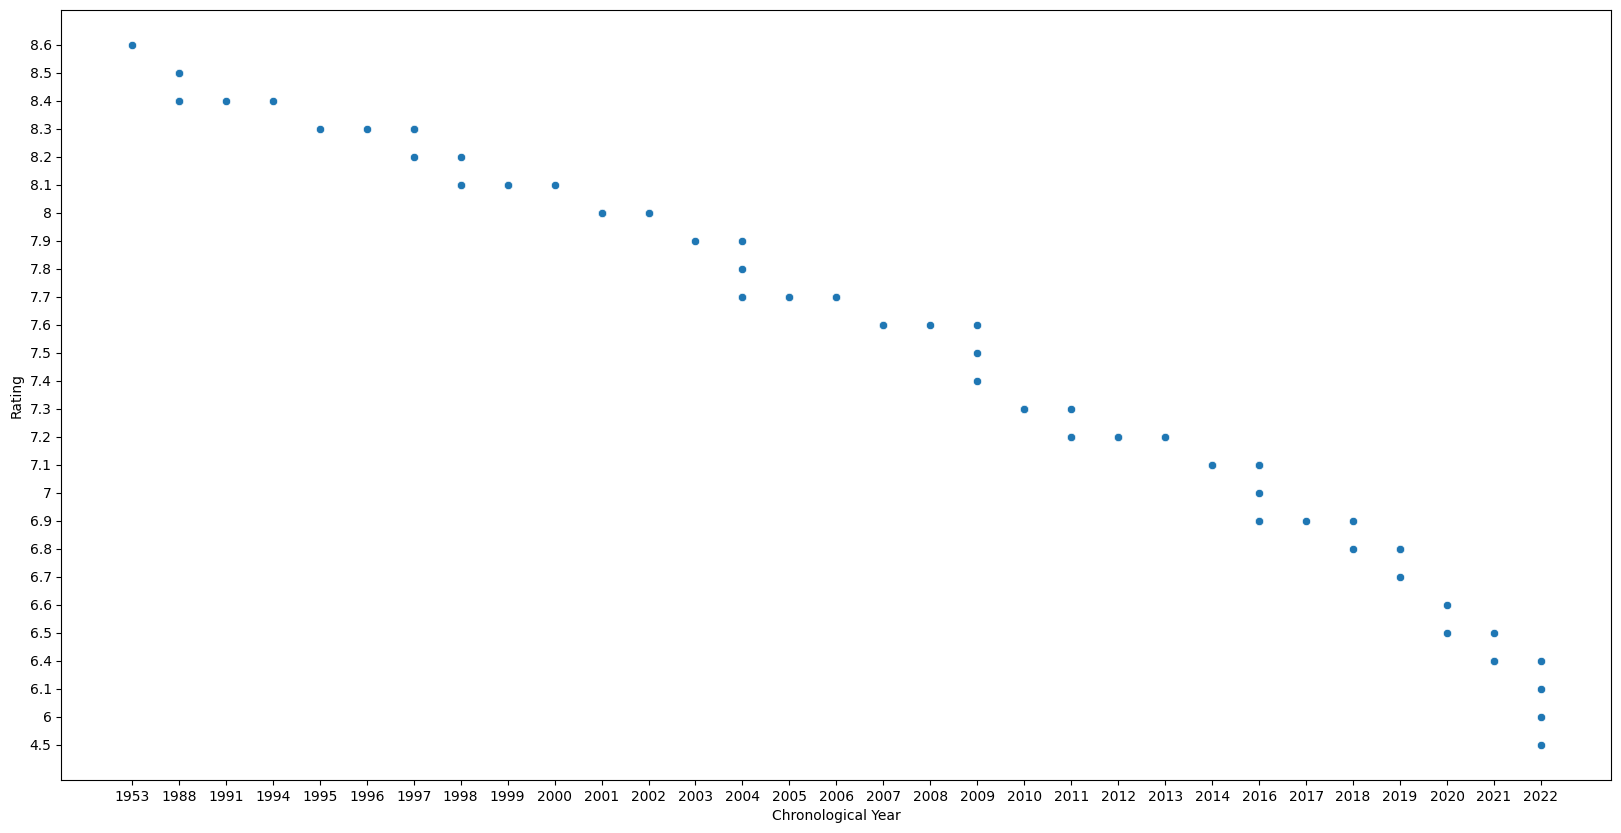

In [23]:
#Analysis of animation
isinstance(full_animation, pd.DataFrame)
import matplotlib.pyplot as plt
import seaborn as sns
full_animation_sorted = full_animation.sort_values('Year')
full_animation['Chronological Year'] = full_animation_sorted['Year'].values
full_animation_sorted2 = full_animation.sort_values('Rating', ascending=False)
full_animation['Rating'] = full_animation_sorted2['Rating'].values
full_animation

plt.figure(figsize=(20,10))
sns.scatterplot(x='Chronological Year', y='Rating', data=full_animation)
plt.show()

#Analysis of animation
isinstance(full_animation, pd.DataFrame)
import matplotlib.pyplot as plt
import seaborn as sns
full__sorted = full_animation.sort_values('Year')
full_animation['Chronological Year'] = full_animation_sorted['Year'].values
full_animation

In [15]:
non_family_animation = df_animation.iloc[non_family_movies(synopsis_list)]; non_family_animation

,Index,Title,Year,Rating,Genre,Synopsis
0,1.,The Super Mario Bros. Movie,2023,7.2,Animation,No Synopsis
1,2.,Puss in Boots: The Last Wish,2022,7.9,Animation,No Synopsis
3,4.,Strange World,2022,5.6,Animation,No Synopsis
4,5.,The Little Mermaid,1989,7.6,Animation,No Synopsis
5,6.,Sing 2,2021,7.4,Animation,No Synopsis
8,9.,Moana,2016,7.6,Animation,No Synopsis
19,20.,Shrek,2001,7.9,Animation,No Synopsis
21,22.,Inside Out,2015,8.1,Animation,No Synopsis
33,34.,Kung Fu Panda,2008,7.6,Animation,No Synopsis
48,49.,Aladdin,1992,8,Animation,No Synopsis


/var/folders/_2/zj00cgg95ts6m3mqz4zzzxym0000gn/T/ipykernel_11709/167214982.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_family_animation['Chronological Year'] = non_family_animation_sorted['Year'].values


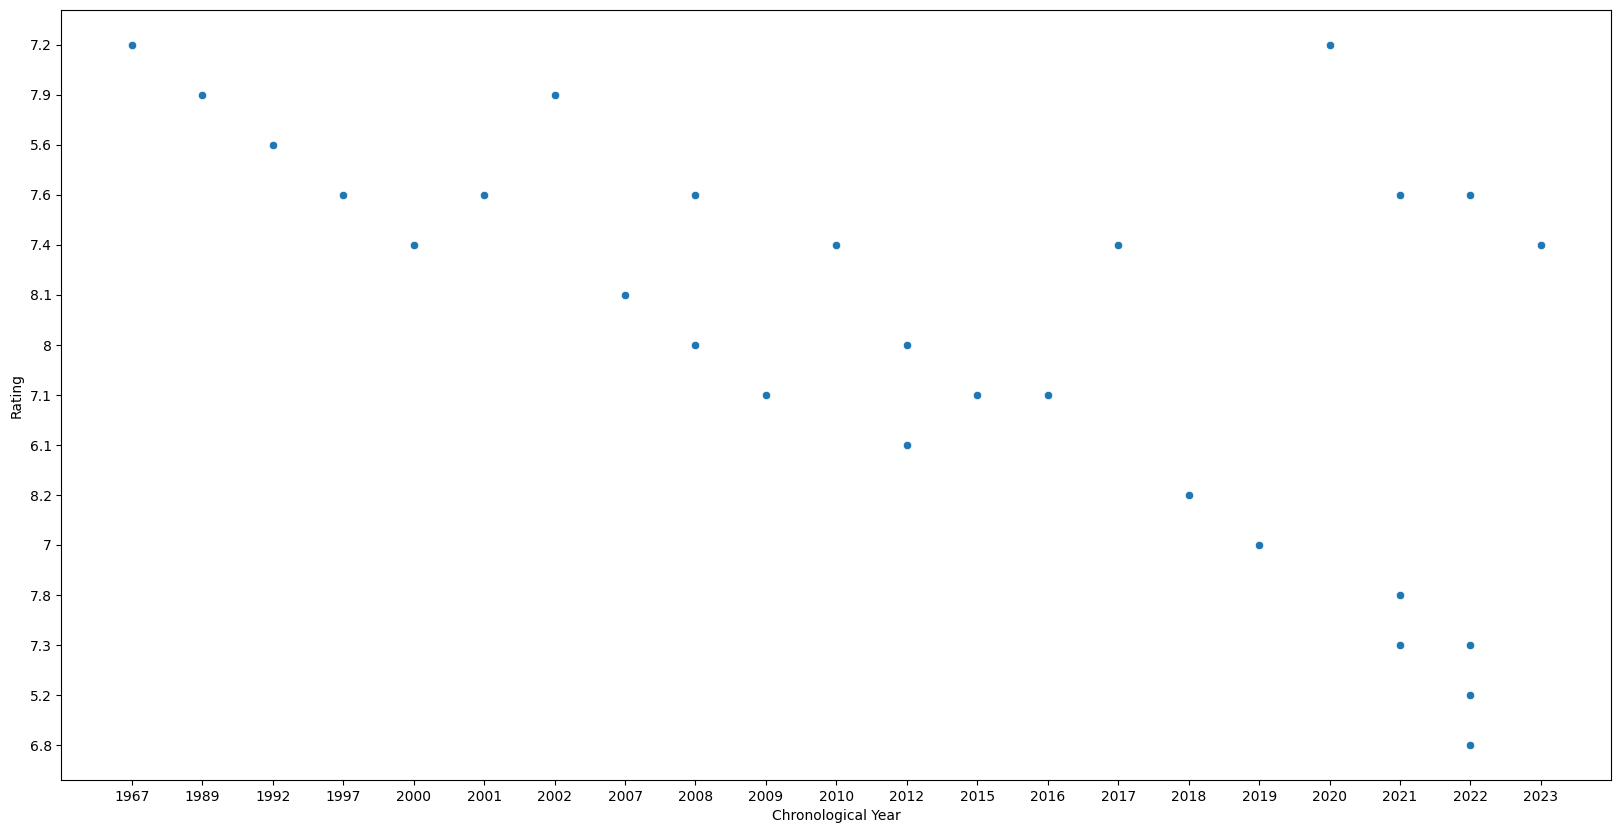

In [16]:
#Analysis of non_family_animation
isinstance(non_family_animation, pd.DataFrame)
import matplotlib.pyplot as plt
import seaborn as sns
non_family_animation_sorted = non_family_animation.sort_values('Year')
non_family_animation['Chronological Year'] = non_family_animation_sorted['Year'].values
non_family_animation_sorted2 = non_family_animation.sort_values('Rating', ascending=False)
non_family_animation['Rating'] = non_family_animation_sorted2['Rating'].values
non_family_animation

plt.figure(figsize=(20,10))
sns.scatterplot(x='Chronological Year', y='Rating', data=non_family_animation)
plt.show()